# **Amazon Lookout for Equipment** - 익명화된 익스펜더 데이터셋에 대한 데모
*파트 1: 데이터 준비*

**버킷 이름을 적합하게 변경하세요**

In [1]:
BUCKET = '<YOUR_BUCKET_NAME_HERE>'
PREFIX = 'data'

## 초기화
---
이 저장소는 처음에는 아래와 같이 구성됩니다.
```
/lookout-equipment-demo
|
+-- dataset/                                <<< 원천 데이터셋 <<<
|   |-- labels.csv
|   |-- tags_description.csv
|   |-- timeranges.txt
|   \-- timeseries.zip
|
+-- notebooks/
|   |-- 1_data_preparation.ipynb            <<< 본 노트북 <<<
|   |-- 2_dataset_creation.ipynb
|   |-- 3_model_training.ipynb
|   |-- 4_model_evaluation.ipynb
|   \-- 5_inference_scheduling.ipynb
|
+-- utils/
    |-- lookout_equipment_utils.py
    \-- lookoutequipment.json
```

### 임포트

In [2]:
%%sh
pip --quiet install --upgrade pip
pip --quiet install --upgrade awscli boto3 tsia

In [3]:
from IPython.core.display import HTML
HTML("<script>Jupyter.notebook.kernel.restart()</script>")

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import shutil
import sys
import tsia
import warnings

from tqdm import tqdm

In [5]:
sys.path.append('../utils')
import lookout_equipment_utils as lookout

### 파라미터

In [6]:
RAW_DATA   = os.path.join('..', 'dataset')
DATA       = os.path.join('..', 'data')
LABEL_DATA = os.path.join(DATA, 'labelled-data')
TRAIN_DATA = os.path.join(DATA, 'training-data', 'expander')

os.makedirs(DATA,       exist_ok=True)
os.makedirs(LABEL_DATA, exist_ok=True)
os.makedirs(TRAIN_DATA, exist_ok=True)

In [7]:
%matplotlib inline
plt.style.use('Solarize_Light2')
plt.rcParams['lines.linewidth'] = 0.5
warnings.filterwarnings("ignore")

## 분석 대상 데이터셋 불러오기
---
### 분석 시간 범위
본 저장소와 함께 제공되는 데이터셋은 1년 기한이며 연초와 연말에 알려진 이상치 일부가 발생합니다. 훈련 / 평가 셋을 아래와 같이 분할하면 Lookout for Equipment가 분할한 기간 양쪽으로 라벨을 갖게 됩니다. 

In [8]:
timeranges_fname = os.path.join(DATA, 'timeranges.txt')
shutil.copyfile(os.path.join(RAW_DATA, 'timeranges.txt'), timeranges_fname)
with open(timeranges_fname, 'r') as f:
    timeranges = f.readlines()
    
training_start   = pd.to_datetime(timeranges[0][:-1])
training_end     = pd.to_datetime(timeranges[1][:-1])
evaluation_start = pd.to_datetime(timeranges[2][:-1])
evaluation_end   = pd.to_datetime(timeranges[3][:-1])

print(f'Training period: from {training_start} to {training_end}')
print(f'Evaluation period: from {evaluation_start} to {evaluation_end}')

Training period: from 2015-01-01 00:00:00 to 2015-08-31 23:59:00
Evaluation period: from 2015-09-01 00:00:00 to 2015-11-30 23:59:00


### 라벨
과거 유지 보수 기록의 시간 범위는 각 범위의 *시작 시간* 과 *종료 시간*, 이 두 개의 열을 갖는 CSV 파일에 따로 기록됩니다.

In [9]:
labels_fname = os.path.join(LABEL_DATA, 'labels.csv')
shutil.copyfile(os.path.join(RAW_DATA, 'labels.csv'), labels_fname)
labels_df = pd.read_csv(os.path.join(LABEL_DATA, 'labels.csv'), header=None)
labels_df[0] = pd.to_datetime(labels_df[0])
labels_df[1] = pd.to_datetime(labels_df[1])
labels_df.columns = ['start', 'end']
labels_df.head()

,start,end
0,2015-01-10 10:00:00,2015-01-10 20:00:00
1,2015-01-15 13:00:00,2015-01-16 15:00:00
2,2015-03-05 10:00:00,2015-03-27 00:00:00
3,2015-03-29 10:00:00,2015-03-29 19:00:00
4,2015-11-11 18:00:00,2015-11-13 12:00:00


### 시계열
원천 시계열은 압축된 Parquet 파일입니다. 압축을 풉시다. 

In [10]:
timeseries_fname = os.path.join(RAW_DATA, 'timeseries.zip')
!unzip -o $timeseries_fname -d $DATA/training-data

Archive:  ../dataset/timeseries.zip
  inflating: ../data/training-data/expander.parquet  


여기에 저장된 Dataframe에는 *2015년 1월 1일* 부터 *11월 30일* 까지 122개의 태그와 480,886개의 행이 존재합니다. 

In [11]:
all_tags_fname = os.path.join(DATA, 'training-data', 'expander.parquet')
table = pq.read_table(all_tags_fname)
all_tags_df = table.to_pandas()
del table

print(all_tags_df.shape)
all_tags_df.head()

(480886, 122)


,signal-001,signal-002,signal-003,signal-004,signal-005,signal-006,signal-007,signal-008,signal-009,signal-010,...,signal-113,signal-114,signal-115,signal-116,signal-117,signal-118,signal-119,signal-120,signal-121,signal-122
Timestamp,,,,,,,,,,,,,,,,,,,,,
2015-01-01 00:00:00,0.392371,0.545005,0.296774,0.413289,0.170744,0.482980,0.222063,0.268691,0.749860,0.475116,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:01:00,0.389415,0.569155,0.290645,0.415646,0.142368,0.532297,0.222063,0.290804,0.776781,0.486884,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.779412,0.810345
2015-01-01 00:02:00,0.378179,0.547750,0.290645,0.406456,0.160959,0.470115,0.235673,0.277115,0.782389,0.472665,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:03:00,0.381135,0.547750,0.284516,0.401744,0.170744,0.498794,0.249284,0.270446,0.771733,0.484432,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345
2015-01-01 00:04:00,0.381135,0.553238,0.284516,0.406456,0.142368,0.493433,0.194842,0.272025,0.749860,0.484432,...,0.939024,0.830769,0.811321,0.653465,0.789474,0.810345,0.803571,0.787879,0.764706,0.810345


### 태그 설명

본 데이터셋에는 다음 내용을 포함하는 태그 설명 파일이 존재합니다.

* `Tag`: 이력 관리 시스템에 고객이 기록한 태그 명 (예컨대 [Honeywell 프로세스 이력 데이터베이스](https://www.honeywellprocess.com/en-US/explore/products/advanced-applications/uniformance/Pages/uniformance-phd.aspx))
* `UOM`: 기록한 신호의 측정 단위
* `Subsystem`: 해당 센서가 연결된 자산 부속의 ID

In [12]:
tags_description_fname = os.path.join(RAW_DATA, 'tags_description.csv')
tags_description_df = pd.read_csv(tags_description_fname)
tags_description_df.head()

,Tag,UOM,Subsystem
0,signal-001,micra pp,subsystem-05
1,signal-002,micra pp,subsystem-05
2,signal-003,micra pp,subsystem-05
3,signal-004,micra pp,subsystem-05
4,signal-005,micra pp,subsystem-08


해당 표에서 피쳐 목록을 뽑아보겠습니다. 편의를 위해 측정 단위 별로 그룹화합니다.

In [13]:
features = list(tags_description_df.sort_values(by='UOM')['Tag'])

## 데이터셋 개요
---

피쳐 당 Dataframe을 하나씩 만들어 List를 생성합니다 (이는 시각화 목적으로 유용합니다). 연초에 이벤트가 쏠려있으므로 시각화 목적으로 해당 부분을 제거합니다. (즉 아래처럼 `start`에서 `end`까지의 기간으로 정의) 그러나 모델 훈련할 때에는 1월 1일부터 시작하는 기간으로 원복합니다.

In [14]:
start = pd.to_datetime('2015-04-05 00:00:00')
end = evaluation_end

df_list = []
feature_groups = dict()
for f in features:
    # 현재 피쳐의 측정 단위를 가져옵니다.
    uom = str(list(tags_description_df.loc[tags_description_df['Tag'] == f, 'UOM'])[0])
    
    # 만약 해당 그룹에 피쳐들이 이미 존재한다면, 현재 피쳐를 추가합니다. 
    if uom in feature_groups.keys():
        feature_groups.update({uom: feature_groups[uom] + [f]})
        
    # 그렇지 않다면 그룹을 생성합니다.
    else:
        feature_groups.update({uom: [f]})
    
    # List에 Dataframe을 추가합니다.
    current_df = all_tags_df.loc[start:end, [f]]
    current_df = current_df.replace(np.nan, 0.0)
    df_list.append(current_df)

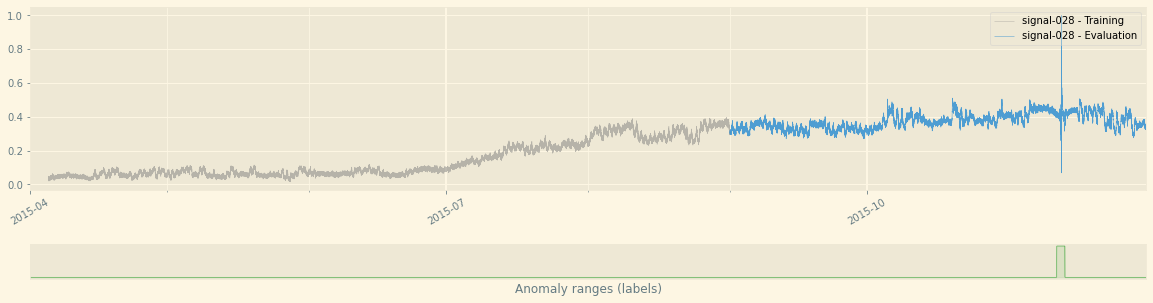

In [15]:
tag = 'signal-028'
tag_df = all_tags_df.loc[start:end, [tag]]
tag_df.columns = ['Value']

fig, axes = lookout.plot_timeseries(
    tag_df, 
    tag, 
    fig_width=20, 
    tag_split=evaluation_start, 
    labels_df=labels_df
)

100%|██████████| 122/122 [00:04<00:00, 24.72it/s]


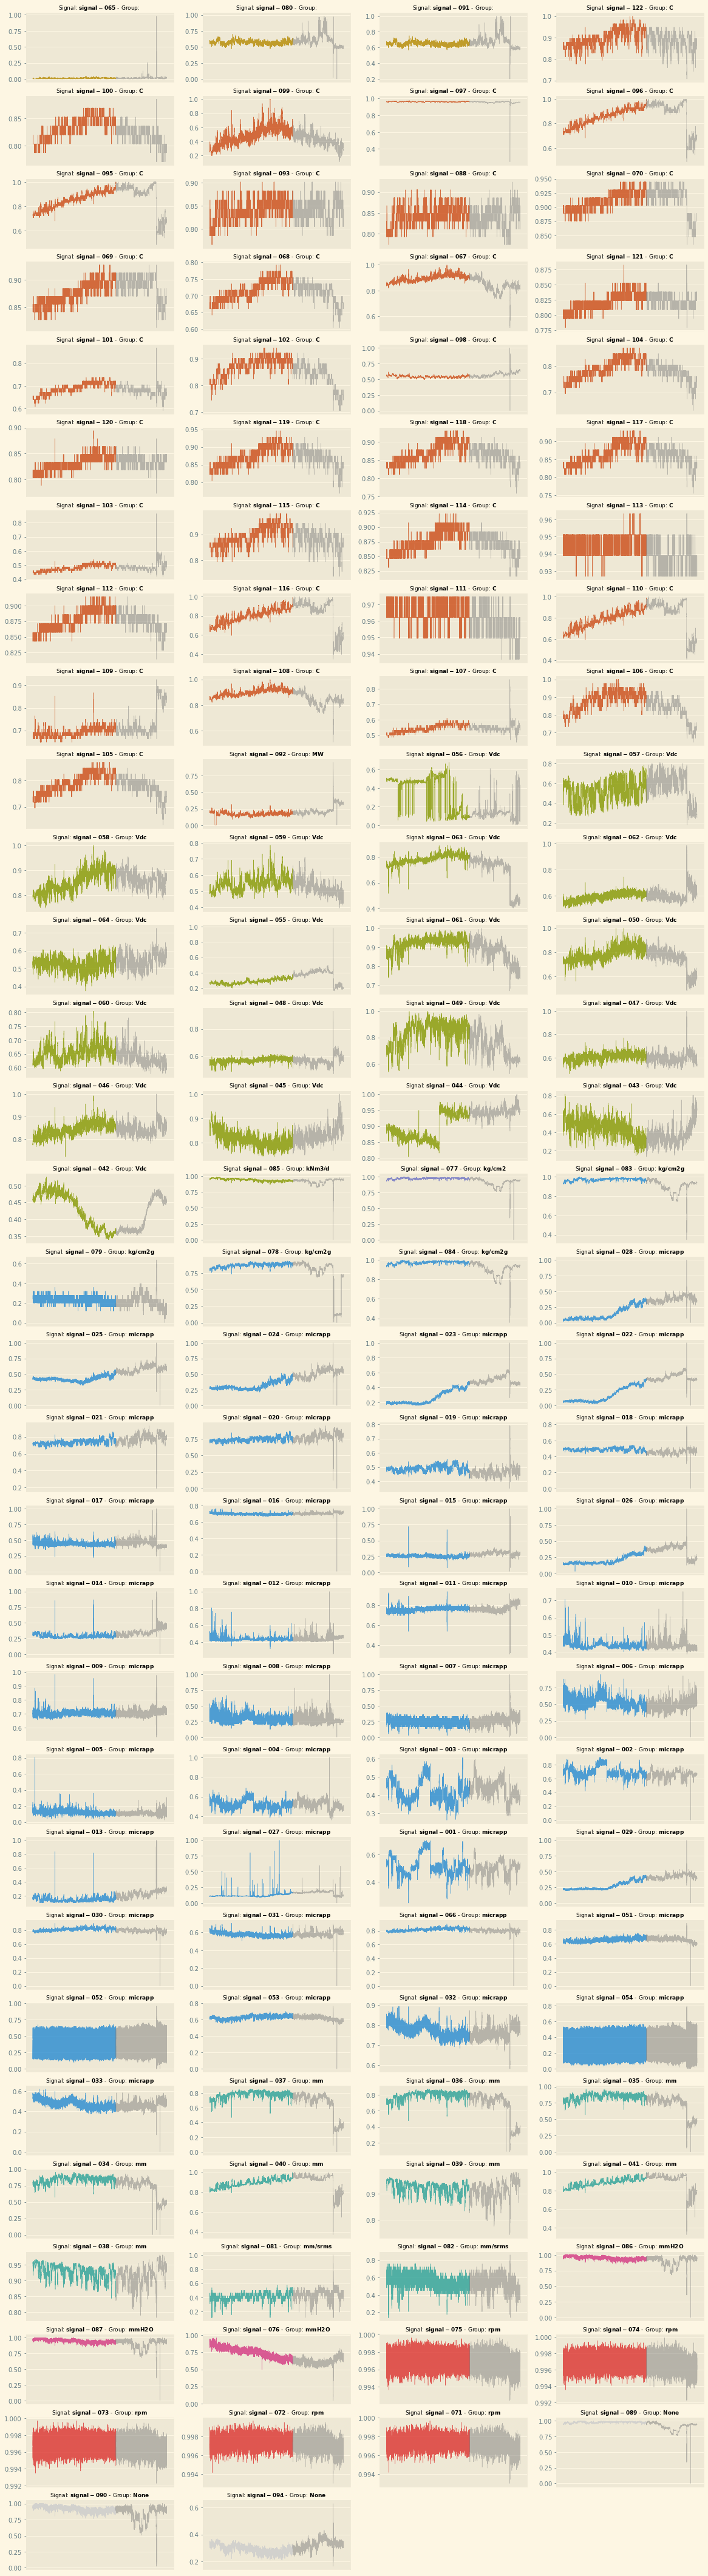

In [16]:
fig = tsia.plot.plot_multivariate_timeseries(
    timeseries_list=df_list,
    tags_list=features,
    split_date=evaluation_start,
    tags_description_df=tags_description_df,
    tags_grouping_key='UOM',
    num_cols=4,
    col_size=5
)

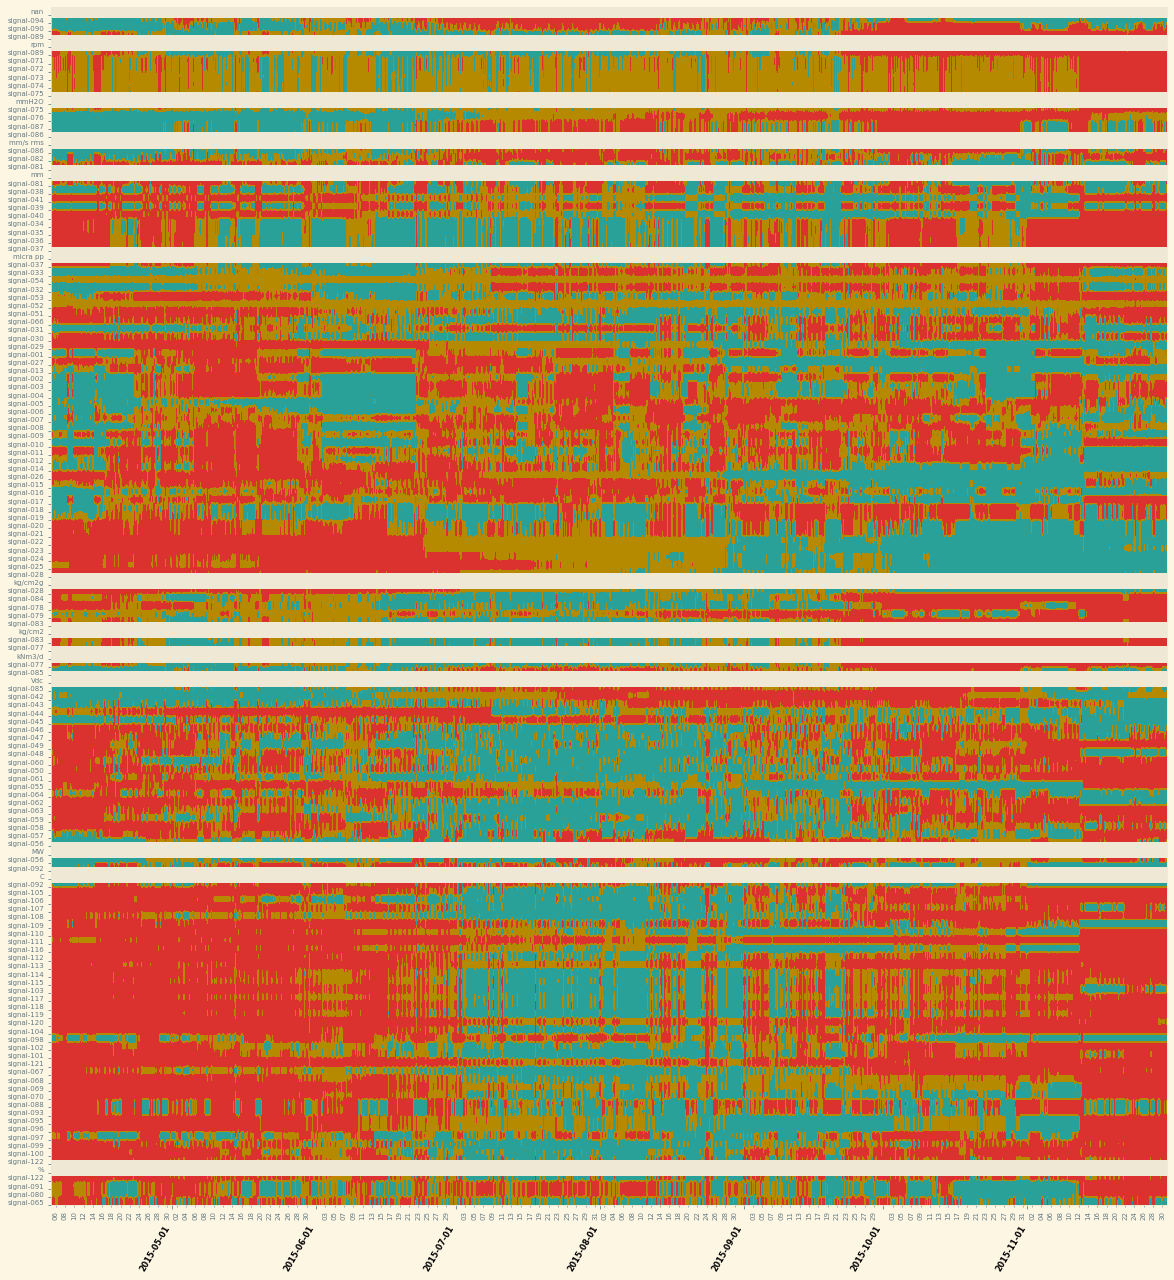

CPU times: user 21.5 s, sys: 1.32 s, total: 22.8 s
Wall time: 23.1 s


In [17]:
%%time
# 각 신호를 3 개의 구간으로 이산화합니다.
array = tsia.markov.discretize_multivariate(df_list)

# 측정 단위(UOM)를 기준으로 신호를 그룹화합니다.
num_timesteps = array.shape[1]
separator = np.zeros(shape=(1, num_timesteps))
separator = np.where(separator==0, np.nan, separator)
grouped_array = []
signal_list = []
current_row = 0
for uom in feature_groups.keys():
    num_features = len(feature_groups[uom])
    signal_list = signal_list + features[current_row:current_row + num_features + 1]
    signal_list.append(uom)
    grouped_array.append(array[current_row:current_row + num_features + 1])
    grouped_array.append(separator)
    current_row += num_features
grouped_array = np.concatenate(grouped_array)

# 스트립 차트를 그립니다.
tsia.plot.plot_timeseries_strip_chart(
  grouped_array, 
  signal_list=signal_list,
  fig_width=20,
  dates=df_list[0].index.to_pydatetime(),
  day_interval=2
)

## 데이터셋을 구성하고 업로드하기
---
다음과 같은 S3 버킷을 구성할 것입니다.
```
s3://sagemaker-lookout-equipment-demo/
|
+-- training-data/
|   |
|   +-- expander/
|       |
|       +-- subsystem-01
|       |   \-- subsystem-01.csv
|       |
|       +-- subsystem-02
|       |   \-- subsystem-02.csv
|       |
|       +-- ...
|       |
|       \-- subsystem-24
|           \-- subsystem-24.csv
|
+-- labelled-data/
    |
    \-- labels.csv
```

In [18]:
# 각 하위 시스템을 하나씩 처리합니다.
components = list(tags_description_df['Subsystem'].unique())
progress_bar = tqdm(components)
for component in progress_bar:
    progress_bar.set_description(f'Component {component}')
    progress_bar.refresh()
    
    # CSV 파일이 이미 존재하는지 확인하고 덮어 쓰지 않게 합니다.
    component_tags_fname = os.path.join(TRAIN_DATA, f'{component}', f'{component}.csv')
    if not os.path.exists(component_tags_fname):
        # 현재 하위 시스템에 대한 신호 시계열 전체를 Dataframe으로 구성합니다.
        component_tags_list = list(tags_description_df[tags_description_df['Subsystem'] == component]['Tag'])
        component_tags_df = all_tags_df[component_tags_list]
        component_tags_df = component_tags_df.reset_index()
        component_tags_df['Timestamp'] = component_tags_df['Timestamp'].dt.strftime('%Y-%m-%dT%H:%M:%S.%f')
        
        # 디스크에 저장합니다.
        os.makedirs(os.path.join(TRAIN_DATA, f'{component}'), exist_ok=True)
        component_tags_df.to_csv(component_tags_fname, index=None)

Component subsystem-17: 100%|██████████| 24/24 [02:25<00:00,  6.08s/it]


In [19]:
# 훈련 데이터셋을 S3에 업로드합니다.
training_src_dir = TRAIN_DATA
training_s3_dest_path = f's3://{BUCKET}/{PREFIX}/training-data/expander'
!aws s3 cp --quiet --recursive $training_src_dir $training_s3_dest_path

In [20]:
# 라벨 데이터셋을 S3에 업로드합니다.
label_src_fname = os.path.join(LABEL_DATA, 'labels.csv')
label_s3_dest_path = f's3://{BUCKET}/{PREFIX}/labelled-data/labels.csv'
!aws s3 cp --quiet $label_src_fname $label_s3_dest_path

## 결론
---
이 단계에서 다음을 생성했습니다.
* 전체 태그에 대해 모든 이력 데이터가 포함된, 고객 제공의 Parquet 단일 데이터셋. 이것은 **태그 122개**에 대해 **1분** 단위로 샘플링한 **관측치 58,668,092개**입니다.
* 해당 하위 시스템 디렉터리에 저장한 **24개의 개별 CSV 파일** (각 하위 시스템마다 1개 씩, 각 하위 시스템은 복수의 시계열을 포함할 수 있음)

위의 **signal-028**에 대한 플롯에서 보듯이 **2015년 11월**에 발생하는 이벤트를 예측하려고 시도할 것입니다. 이를 달성하기 위해 **2015년 1월**부터 **2015년 8월**까지의 훈련 셋을 사용하여 **2015년 9월**부터 **2015년 11월**까지 테스트할 것입니다.